In [4]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
n_pc_samples = 2048
do_training = False
first_time_running = False
load_model = True
seed = 42
GPU = [0]
max_training_epochs = 1000
loss = 'chamfer'
experiment_name = '1_three_fc_dec_spn_' + str(n_pc_samples) +  'pts_' + loss

In [7]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
train_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae/')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/vanilla_ae/1_three_fc_dec_spn_2048pts_chamfer'

In [8]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')

In [9]:
full_pclouds, full_model_names, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,\
                                                                           n_threads=40, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

57449 files containing complete point clouds were found.


/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/tf_lab/point_clouds/in_out.py:56: UserWarning: Point clouds with the same model name were loaded.
  warnings.warn('Point clouds with the same model name were loaded.')


In [10]:
# np.random.seed(seed)
# tf.set_random_seed(seed)

# train_data_, val_data_, test_data_, r_indices = pio.train_validate_test_split(
#                                                             [full_pclouds, full_model_names],
#                                                             train_perc=0.85,
#                                                             validate_perc=0.05,
#                                                             test_perc=0.1,
#                                                             seed=seed)

# model_ids = np.vstack((full_model_names, full_syn_ids)).T

# if first_time_running:
#     write_model_ids_of_datasets(train_dir, model_ids, r_indices)

# train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
# val_data = PointCloudDataSet(val_data_[0], labels=val_data_[1])
# test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])

model_unames = full_model_names + '_' + full_syn_ids
train_data = PointCloudDataSet(full_pclouds, labels=model_unames)

In [11]:
if load_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
else:
    n_input = [n_pc_samples, 3]

    decoder_args = {'layer_sizes': [512, 1024, np.prod(n_input)], 
                    'non_linearity': tf.nn.relu
                   }

    conf = Conf(
                n_input = n_input,
                training_epochs = max_training_epochs,
                batch_size = 50,
                loss = loss,
                denoising = False,
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 10,
                learning_rate = 0.0005,
                z_rotate = True,
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args,
               )

    conf.experiment_name = experiment_name
    conf.save(osp.join(conf.train_dir, 'configuration'))
    

reset_tf_graph()
set_visible_GPUs([GPU])

ae = PointNetAutoEncoder(experiment_name, conf)

if load_model:
    saved_epochs = read_saved_epochs(conf.train_dir)
    last_epoch = saved_epochs[-1]
    ae.restore_model(conf.train_dir, last_epoch, verbose=True)

                    batch_size: 50
                 consistent_io: None
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'non_linearity': <function relu at 0x7f7b69d49e60>, 'layer_sizes': [512, 1024, 6144]}
                       encoder: encoder_with_convs_and_symmetry
                  encoder_args: {}
               experiment_name: 1_three_fc_dec_spn_2048pts_chamfer
                 gauss_augment: None
                  is_denoising: False
               latent_vs_recon: 1.0
                 learning_rate: 0.0005
                          loss: chamfer
             loss_display_step: 1
                       n_input: [2048, 3]
                      n_output: [2048, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 10
                     train_dir: /orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/vanilla_ae/1_three_fc_dec_spn_2048pts_cham

In [12]:
if do_training:
    training_stats = []
    training_stats.append(ae.train(train_data, conf))    
    with open(osp.join(conf.train_dir, 'train_stats.txt'), 'a') as fout:
        np.savetxt(fout, np.array(training_stats)[0])

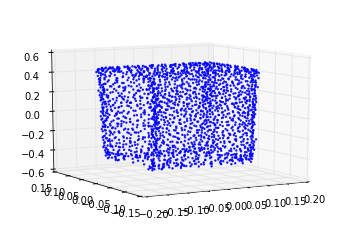

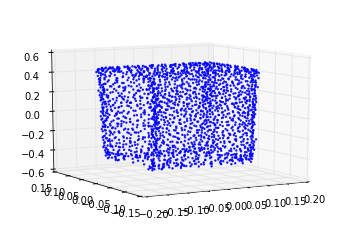

In [13]:
Point_Cloud(ae.reconstruct(train_data.next_batch(1)[0])[0][0]).plot()

In [14]:
r0, r1, r2 = train_data.next_batch(500)
td = PointCloudDataSet(r0, labels=r1)
res = ae.evaluate(td, conf)
print res[1]


0.000503272912465
